**Note to grader:** Each question consists of parts, e.g. Q1(i), Q1(ii), etc. Each part must be first graded  on a 0-4 scale, following the standard NJIT convention (A:4, B+: 3.5, B:3, C+: 2.5, C: 2, D:1, F:0). However, any given item may be worth 4 or 8 points; if an item is worth 8 points, you need to accordingly scale the 0-4 grade.


The total score must be re-scaled to 100. That should apply to all future assignments so that Canvas assigns the same weight on all assignments. 



**Installing and Importing required modules**

In [1]:
!pip install d2l==0.16.1
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import os
import torch, torchmetrics
import torchvision
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import requests
import time
from tqdm import tqdm
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
from torchvision.datasets import ImageFolder
from pathlib import Path
from datetime import datetime
from d2l import torch as d2l
from PIL import Image
%matplotlib inline

# Use a white background for matplotlib figures
matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [3]:
# Torchinfo, install if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

In [4]:
from google.colab import drive
drive.mount('/content/data', force_remount=True)

Mounted at /content/data


In [5]:
# Checking if GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [6]:
# Personal tracking for time to compare
from timeit import default_timer as timer 
def print_train_time(start: float, end: float, device: torch.device = device):
    """Prints difference between start and end time.

    Args:
        start (float): Start time of computation (preferred in timeit format). 
        end (float): End time of computation.
        device ([type], optional): Device that compute is running on. Defaults to None.

    Returns:
        float: time between start and end in seconds (higher is longer).
    """
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

# <font color = 'green'>  **Assignment 3**

This assignment tries to further develop your understanding of Convolutional Neural Networks. The notebook is based on the Alexnet noteebook from lecture 4.


In [7]:
net = nn.Sequential(
    # Here, we use a larger 11 x 11 window to capture objects. At the same
    # time, we use a stride of 4 to greatly reduce the height and width of the
    # output. Here, the number of output channels is much larger than that in
    # LeNet
    nn.Conv2d(1, 96, kernel_size=11, stride=4, padding=1), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    # Make the convolution window smaller, set padding to 2 for consistent
    # height and width across the input and output, and increase the number of
    # output channels
    nn.Conv2d(96, 256, kernel_size=5, padding=2), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    # Use three successive convolutional layers and a smaller convolution
    # window. Except for the final convolutional layer, the number of output
    # channels is further increased. Pooling layers are not used to reduce the
    # height and width of input after the first two convolutional layers
    nn.Conv2d(256, 384, kernel_size=3, padding=1), nn.ReLU(),
    nn.Conv2d(384, 384, kernel_size=3, padding=1), nn.ReLU(),
    nn.Conv2d(384, 256, kernel_size=3, padding=1), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    nn.Flatten(),
    # Here, the number of outputs of the fully-connected layer is several
    # times larger than that in LeNet. Use the dropout layer to mitigate
    # overfitting
    nn.Linear(6400, 4096), nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(4096, 4096), nn.ReLU(),
    nn.Dropout(p=0.5),
    # Output layer. Since we are using Fashion-MNIST, the number of classes is
    # 10, instead of 1000 as in the paper
    nn.Linear(4096, 10))

We construct a single-channel data example with both height and width of 224 to observe the output shape of each layer. 


In [8]:
X = torch.randn(1, 1, 224, 224)
for layer in net:
    X=layer(X)
    print(layer.__class__.__name__,'Output shape:\t',X.shape)

Conv2d Output shape:	 torch.Size([1, 96, 54, 54])
ReLU Output shape:	 torch.Size([1, 96, 54, 54])
MaxPool2d Output shape:	 torch.Size([1, 96, 26, 26])
Conv2d Output shape:	 torch.Size([1, 256, 26, 26])
ReLU Output shape:	 torch.Size([1, 256, 26, 26])
MaxPool2d Output shape:	 torch.Size([1, 256, 12, 12])
Conv2d Output shape:	 torch.Size([1, 384, 12, 12])
ReLU Output shape:	 torch.Size([1, 384, 12, 12])
Conv2d Output shape:	 torch.Size([1, 384, 12, 12])
ReLU Output shape:	 torch.Size([1, 384, 12, 12])
Conv2d Output shape:	 torch.Size([1, 256, 12, 12])
ReLU Output shape:	 torch.Size([1, 256, 12, 12])
MaxPool2d Output shape:	 torch.Size([1, 256, 5, 5])
Flatten Output shape:	 torch.Size([1, 6400])
Linear Output shape:	 torch.Size([1, 4096])
ReLU Output shape:	 torch.Size([1, 4096])
Dropout Output shape:	 torch.Size([1, 4096])
Linear Output shape:	 torch.Size([1, 4096])
ReLU Output shape:	 torch.Size([1, 4096])
Dropout Output shape:	 torch.Size([1, 4096])
Linear Output shape:	 torch.Size([1,

## Reading the Dataset

Although AlexNet is trained on ImageNet in the paper, we use Fashion-MNIST here
since training an ImageNet model to convergence could take hours or days
even on a modern GPU.
One of the problems with applying AlexNet directly on Fashion-MNIST
is that its images have lower resolution ($28 \times 28$ pixels)
than ImageNet images.
To make things work, we upsample them to $224 \times 224$
(generally not a smart practice,
but we do it here to be faithful to the AlexNet architecture).
We perform this resizing with the `resize` argument in the `d2l.load_data_fashion_mnist` function.


In [9]:
batch_size0 = 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size0, resize=224)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


loss 0.330, train acc 0.880, test acc 0.877
1445.2 examples/sec on cuda:0
Train time on cuda:0: 549.853 seconds
CPU times: user 6min 47s, sys: 42.4 s, total: 7min 29s
Wall time: 9min 9s


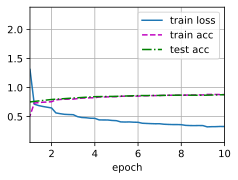

In [10]:
%%time
train_time_start_model0 = timer()

lr, num_epochs = 0.01, 10
model0 = d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr)
model0

# Personal tracker for comparison
train_time_end_model0 = timer()
total_train_time_model0 = print_train_time(start=train_time_start_model0,
                                           end=train_time_end_model0,
                                           device=device)

 

## <font color = 'red'>  **Question 1** <font>

<font color = 'red'>  Alexnet was written for images of size 224x224. Clearly it is an overkill for the Fashion MNIST data set which has size 28x28. 

<font color = 'red'> (i) Construct a model that mimics the architecture of Alexnet, but works directly on images of size 28x28. 

<font color = 'red'> (ii) What is the accuracy you reach? 

<font color = 'red'> (iii) Also compare the running time of your model with that of the original Alexnet on the resized images. 

<font color = 'red'>[**Guidelines**: In general, here you probably want to use smaller kernels, and fewers convolutional layers. The most important part of this exercise is to get the dimensions of the layers correct, so that the model works. Try not to use 'Lazy' layers, so that you better understand the dimensions. Also some experimentation with different designs would be good. Feel free to discuss all experiments you did.]


# <font color = 'red'>  **Model restructuring** <font># 

In [11]:
# Loading dataset
train_data = torchvision.datasets.FashionMNIST(root='.', download=True, train=True, transform=ToTensor())
test_data = torchvision.datasets.FashionMNIST(root='.', train=False, transform=ToTensor())

In [12]:
print(len(train_data), len(test_data))

60000 10000


In [13]:
# Use random_split helper function to set aside 10000 images for our validation set.
random_seed = 42
torch.manual_seed(random_seed);

val_size = 10000
train_size = len(train_data) - val_size
train_ds, val_ds = random_split(train_data, [train_size, val_size])
print(len(train_ds), len(val_ds))

50000 10000


In [14]:
# Simple model to inspect
simple_model = nn.Sequential(
    nn.Conv2d(1, 10, kernel_size=3, stride=1, padding=1),
    nn.MaxPool2d(2, 2)
)

In [15]:
# Checking shapes
for images, labels in train_ds:
    print('images.shape:', images.shape)
    out = simple_model(images)
    print('out.shape:', out.shape)
    break

images.shape: torch.Size([1, 28, 28])
out.shape: torch.Size([10, 14, 14])


In [16]:
# Create data loaders for training, testing and validating. NOTE: loaders consume CPU, adding below to help:
# (i) pin_memory enables fast data transfer to CUDA-enabled GPUs
# (ii) num_workers (if set to 0 = slower training) allows dataset access together with its internal IO, 
# transforms (optional: including collate_fn) runs in the worker process.
batch_size = 32

train_loader = DataLoader(train_ds, batch_size=batch_size)
val_loader = DataLoader(val_ds, batch_size=batch_size*2)
test_loader = DataLoader(test_data, batch_size=batch_size*2)

# Print DataLoaders
print(f"DataLoaders: {train_loader, val_loader, test_loader}")
print(f"Length of train_loader: {len(train_loader)} batches of {batch_size}...")
print(f"Length of val_loader: {len(val_loader)} batches of {batch_size}...")
print(f"Length of test_loader: {len(test_loader)} batches of {batch_size}...")

DataLoaders: (<torch.utils.data.dataloader.DataLoader object at 0x7f0c361a5310>, <torch.utils.data.dataloader.DataLoader object at 0x7f0c361a53d0>, <torch.utils.data.dataloader.DataLoader object at 0x7f0c34cc1190>)
Length of train_loader: 1563 batches of 32...
Length of val_loader: 157 batches of 32...
Length of test_loader: 157 batches of 32...


In [17]:
# Mimick AlexNet on 28 x 28 images 
class FMNIST_AlexNet(nn.Module):
    
    def __init__(self):
        super(FMNIST_AlexNet, self).__init__()
        # input: 28 * 28 * 3, output: 28 * 28 * 32
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2) # input: 28 * 28 * 32, output: 14 * 14 * 32
        )
        # input: 14 * 14 * 32, output: 12 * 12 * 64
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2) # 12 * 12 * 64, output: 6 * 6 * 64
        )
        
        self.fc1 = nn.Linear(in_features=64*6*6, out_features=600)
        self.drop = nn.Dropout2d(0.25)
        self.fc2 = nn.Linear(in_features=600, out_features=120)
        self.fc3 = nn.Linear(in_features=120, out_features=10) # final fully connected layer has 10 output features
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)
        
        return out

In [18]:
# Instantiate Model 1
epochs = 10
lr = 0.01
model1 = FMNIST_AlexNet()
model1

FMNIST_AlexNet(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=2304, out_features=600, bias=True)
  (drop): Dropout2d(p=0.25, inplace=False)
  (fc2): Linear(in_features=600, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=10, bias=True)
)

In [19]:
# Training set framework
def train_model(model, loss_fn, optimizer, train_loader, val_loader, epochs=10):
  """
  Train model
  """
  model.to(device)
  train_losses, val_losses = [], []
  for epoch in range(epochs):
    train_samples = 0
    train_acc = 0.0
    train_loss = []
    for x_batch, y_batch in train_loader:
      model.train()
      x_batch = x_batch.to(device)
      y_batch = y_batch.to(device)
      yhat = model(x_batch)
      loss = loss_fn(yhat, y_batch.view(-1))
      loss.backward()
      train_loss.append(loss.item())
      optimizer.step()
      optimizer.zero_grad()

      train_samples += y_batch.shape[0]
      train_acc += accuracy(yhat, y_batch)

    # Add training loss for epoch
    train_losses.append(np.mean(train_loss))

    # Validation loop
    with torch.no_grad():
      val_samples = 0
      val_acc = 0.0
      val_loss = []
      for x_batch, y_batch in val_loader:
        model.eval()
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        yhat = model(x_batch)
        loss = loss_fn(yhat, y_batch.view(-1))
        val_loss.append(loss.item())
        val_samples += y_batch.shape[0]
        val_acc += accuracy(yhat, y_batch)
    val_losses.append(np.mean(val_loss))

    if epoch % 2 == 0:
      print(f"Epoch {epoch} train accuracy: {100.0*train_acc/train_samples:0.3f}, validation accuracy: {100.0*val_acc/val_samples:0.3f}")

  return model, train_losses, val_losses

In [20]:
def accuracy(y_hat, y, averaged=True):
  y_hat = y_hat.reshape((-1, y_hat.shape[-1]))
  preds = y_hat.argmax(axis=1).type(y.dtype)
  compare = (preds == y.reshape(-1)).type(torch.float32)
  return compare.mean() if averaged else compare

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch 0 train accuracy: 2.577, validation accuracy: 1.340
Epoch 2 train accuracy: 2.801, validation accuracy: 1.396
Epoch 4 train accuracy: 2.849, validation accuracy: 1.407
Epoch 6 train accuracy: 2.880, validation accuracy: 1.426
Epoch 8 train accuracy: 2.907, validation accuracy: 1.428
Train time on cuda:0: 99.376 seconds
CPU times: user 1min 38s, sys: 1.31 s, total: 1min 39s
Wall time: 1min 39s


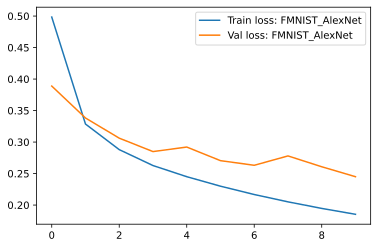

In [21]:
%%time
# Training Model 1
torch.manual_seed(42)
train_time_start_model1 = timer()

# Start and save
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model1.parameters(), lr=lr)
model1, train_losses, val_losses = train_model(model1, loss_fn, optimizer, train_loader, val_loader, epochs)
torch.save(model1.state_dict(), "FMNIST_AlexNet.pt")
# Plotting
plt.plot(train_losses, label = 'Train loss: FMNIST_AlexNet')
plt.plot(val_losses, label = 'Val loss: FMNIST_AlexNet')
plt.legend()
plt.show

# Calling personal tracker
train_time_end_model1 = timer()
total_train_time_model1 = print_train_time(start=train_time_start_model1,
                                           end=train_time_end_model1,
                                           device=device)

In [22]:
model1.state_dict()

OrderedDict([('layer1.0.weight',
              tensor([[[[-6.2966e-02, -8.9312e-02, -3.0959e-02],
                        [ 2.7562e-02,  7.4395e-02, -8.1159e-02],
                        [-2.3289e-01, -2.3734e-01,  5.8246e-02]]],
              
              
                      [[[ 2.3578e-01, -2.7678e-01, -1.0569e-01],
                        [-2.0519e-01, -3.0620e-01, -9.2789e-02],
                        [ 1.0875e-01, -8.3103e-02, -1.8448e-01]]],
              
              
                      [[[ 1.4701e-03, -3.3767e-01,  4.0795e-01],
                        [-9.7125e-02,  3.5888e-01, -1.6551e-01],
                        [ 1.3960e-01, -5.1025e-03, -2.1024e-01]]],
              
              
                      [[[-2.1468e-02, -2.9002e-01, -1.4332e-01],
                        [ 1.5095e-01, -3.4695e-01, -1.5886e-01],
                        [-1.8432e-01,  2.9937e-01, -3.2704e-02]]],
              
              
                      [[[-5.7502e-03, -2.6562e-01,  9.6306e

In [23]:
compare_results = pd.DataFrame([total_train_time_model0, total_train_time_model1])
compare_results

,0
0,549.852810
1,99.376462


In [24]:
# for grader use only

# insert grade here  (out of 12)

# G[1] = 
#
# please justify point subtractions when needed

 

## <font color = 'red'>  **Question 2** <font>

<font color = 'red'>  Now let's go back to the original Alexnet. In the class we trained it for 10 epochs. 

<font color = 'red'>  (i) Train it for 50 epochs and record the training and test accuracy. 

<font color = 'red'>  (ii) Take the MNIST dataloader and modify it, so that each image in the dataset gets a **random** label, in place of its correct label. 

<font color = 'red'>  (iii) Retrain AlexNet with the new modified dataset. This time train it for 500 epochs. What is the training and test accuracy? Can you justify them? Discuss your thoughts. 





In [25]:
from torch.utils.data import DataLoader

# Setup the batch size hyperparameter
BATCH_SIZE = 32

# Turn datasets into iterables (batches)
train_dataloader = DataLoader(train_data, # dataset to turn into iterable
    batch_size=BATCH_SIZE, # how many samples per batch? 
    shuffle=True # shuffle data every epoch?
)

test_dataloader = DataLoader(test_data,
    batch_size=BATCH_SIZE,
    shuffle=False # don't necessarily have to shuffle the testing data
)

# Let's check out what we've created
print(f"Dataloaders: {train_dataloader, test_dataloader}") 
print(f"Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")

Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x7f0c3037d950>, <torch.utils.data.dataloader.DataLoader object at 0x7f0c3037d910>)
Length of train dataloader: 1875 batches of 32
Length of test dataloader: 313 batches of 32


In [26]:
# Check out what's inside the training dataloader
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

In [27]:
# Create a flatten layer
flatten_model = nn.Flatten() # all nn modules function as a model (can do a forward pass)

# Get a single sample
x = train_features_batch[0]

# Flatten the sample
output = flatten_model(x) # perform forward pass

# Print out what happened
print(f"Shape before flattening: {x.shape} -> [color_channels, height, width]")
print(f"Shape after flattening: {output.shape} -> [color_channels, height*width]")

# Try uncommenting below and see what happens
#print(x)
#print(output)

Shape before flattening: torch.Size([1, 28, 28]) -> [color_channels, height, width]
Shape after flattening: torch.Size([1, 784]) -> [color_channels, height*width]


In [28]:
class FashionMNISTModelV0(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(), # neural networks like their inputs in vector form
            nn.Linear(in_features=input_shape, out_features=hidden_units), # in_features = number of features in a data sample (784 pixels)
            nn.Linear(in_features=hidden_units, out_features=output_shape)
        )
    
    def forward(self, x):
        return self.layer_stack(x)

In [29]:
# See classes
class_names = train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [30]:
torch.manual_seed(42)

# Need to setup model with input parameters
model_0 = FashionMNISTModelV0(input_shape=784, # one for every pixel (28x28)
    hidden_units=10, # how many units in the hiden layer
    output_shape=len(class_names) # one for every class
)
model_0.to("cpu") # keep model on CPU to begin with

FashionMNISTModelV0(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [31]:
import requests
from pathlib import Path 

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  # Note: you need the "raw" GitHub URL for this to work
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

helper_functions.py already exists, skipping download


In [32]:
# Import accuracy metric
from helper_functions import accuracy_fn # Note: could also use torchmetrics.Accuracy()

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss() # this is also called "criterion"/"cost function" in some places
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)

In [33]:
# Import tqdm for progress bar
from tqdm.auto import tqdm

# Set the seed and start the timer
torch.manual_seed(42)
train_time_start_on_cpu = timer()

# Set the number of epochs (we'll keep this small for faster training times)
epochs = 3

# Create training and testing loop
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n-------")
    ### Training
    train_loss = 0
    # Add a loop to loop through training batches
    for batch, (X, y) in enumerate(train_dataloader):
        model_0.train() 
        # 1. Forward pass
        y_pred = model_0(X)

        # 2. Calculate loss (per batch)
        loss = loss_fn(y_pred, y)
        train_loss += loss # accumulatively add up the loss per epoch 

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Print out how many samples have been seen
        if batch % 400 == 0:
            print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples")

    # Divide total train loss by length of train dataloader (average loss per batch per epoch)
    train_loss /= len(train_dataloader)
    
    ### Testing
    # Setup variables for accumulatively adding up loss and accuracy 
    test_loss, test_acc = 0, 0 
    model_0.eval()
    with torch.inference_mode():
        for X, y in test_dataloader:
            # 1. Forward pass
            test_pred = model_0(X)
           
            # 2. Calculate loss (accumatively)
            test_loss += loss_fn(test_pred, y) # accumulatively add up the loss per epoch

            # 3. Calculate accuracy (preds need to be same as y_true)
            test_acc += accuracy_fn(y_true=y, y_pred=test_pred.argmax(dim=1))
        
        # Calculations on test metrics need to happen inside torch.inference_mode()
        # Divide total test loss by length of test dataloader (per batch)
        test_loss /= len(test_dataloader)

        # Divide total accuracy by length of test dataloader (per batch)
        test_acc /= len(test_dataloader)

    ## Print out what's happening
    print(f"\nTrain loss: {train_loss:.5f} | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%\n")

# Calculate training time      
train_time_end_on_cpu = timer()
total_train_time_model_0 = print_train_time(start=train_time_start_on_cpu, 
                                           end=train_time_end_on_cpu,
                                           device=str(next(model_0.parameters()).device))

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
-------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train loss: 0.59039 | Test loss: 0.50954, Test acc: 82.04%

Epoch: 1
-------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train loss: 0.47633 | Test loss: 0.47989, Test acc: 83.20%

Epoch: 2
-------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train loss: 0.45503 | Test loss: 0.47664, Test acc: 83.43%

Train time on cpu: 26.137 seconds


In [34]:
torch.manual_seed(42)
def eval_model(model: torch.nn.Module, 
               data_loader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               accuracy_fn):
    """Returns a dictionary containing the results of model predicting on data_loader.

    Args:
        model (torch.nn.Module): A PyTorch model capable of making predictions on data_loader.
        data_loader (torch.utils.data.DataLoader): The target dataset to predict on.
        loss_fn (torch.nn.Module): The loss function of model.
        accuracy_fn: An accuracy function to compare the models predictions to the truth labels.

    Returns:
        (dict): Results of model making predictions on data_loader.
    """
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            # Make predictions with the model
            y_pred = model(X)
            
            # Accumulate the loss and accuracy values per batch
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y_true=y, 
                                y_pred=y_pred.argmax(dim=1)) # For accuracy, need the prediction labels (logits -> pred_prob -> pred_labels)
        
        # Scale loss and acc to find the average loss/acc per batch
        loss /= len(data_loader)
        acc /= len(data_loader)
        
    return {"model_name": model.__class__.__name__, # only works when model was created with a class
            "model_loss": loss.item(),
            "model_acc": acc}

# Calculate model 0 results on test dataset
model_0_results = eval_model(model=model_0, data_loader=test_dataloader,
    loss_fn=loss_fn, accuracy_fn=accuracy_fn
)
model_0_results

{'model_name': 'FashionMNISTModelV0',
 'model_loss': 0.47663894295692444,
 'model_acc': 83.42651757188499}

In [35]:
# Create a model with non-linear and linear layers
class FashionMNISTModelV1(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(), # flatten inputs into single vector
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_shape),
            nn.ReLU()
        )
    
    def forward(self, x: torch.Tensor):
        return self.layer_stack(x)

In [36]:
torch.manual_seed(42)
model_1 = FashionMNISTModelV1(input_shape=784, # number of input features
    hidden_units=10,
    output_shape=len(class_names) # number of output classes desired
).to(device) # send model to GPU if it's available
next(model_1.parameters()).device # check model device

device(type='cuda', index=0)

In [37]:
from helper_functions import accuracy_fn
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_1.parameters(), 
                            lr=0.1)

In [38]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
    train_loss, train_acc = 0, 0
    for batch, (X, y) in enumerate(data_loader):
        # Send data to GPU
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y_true=y,
                                 y_pred=y_pred.argmax(dim=1)) # Go from logits -> pred labels

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

    # Calculate loss and accuracy per epoch and print out what's happening
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")

def test_step(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
    test_loss, test_acc = 0, 0
    model.eval() # put model in eval mode
    # Turn on inference context manager
    with torch.inference_mode(): 
        for X, y in data_loader:
            # Send data to GPU
            X, y = X.to(device), y.to(device)
            
            # 1. Forward pass
            test_pred = model(X)
            
            # 2. Calculate loss and accuracy
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y_true=y,
                y_pred=test_pred.argmax(dim=1) # Go from logits -> pred labels
            )
        
        # Adjust metrics and print out
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")

In [49]:
torch.manual_seed(42)

# Measure time
from timeit import default_timer as timer
train_time_start_on_gpu = timer()

epochs = 50
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n---------")
    train_step(data_loader=train_dataloader, 
        model=model_1, 
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn
    )
    test_step(data_loader=test_dataloader,
        model=model_1,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn
    )

train_time_end_on_gpu = timer()
total_train_time_model_1 = print_train_time(start=train_time_start_on_gpu,
                                            end=train_time_end_on_gpu,
                                            device=device)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 0.64302 | Train accuracy: 76.43%
Test loss: 0.68500 | Test accuracy: 75.02%

Epoch: 1
---------
Train loss: 0.64302 | Train accuracy: 76.43%
Test loss: 0.68500 | Test accuracy: 75.02%

Epoch: 2
---------
Train loss: 0.64302 | Train accuracy: 76.43%
Test loss: 0.68500 | Test accuracy: 75.02%

Epoch: 3
---------
Train loss: 0.64302 | Train accuracy: 76.43%
Test loss: 0.68500 | Test accuracy: 75.02%

Epoch: 4
---------
Train loss: 0.64302 | Train accuracy: 76.43%
Test loss: 0.68500 | Test accuracy: 75.02%

Epoch: 5
---------
Train loss: 0.64302 | Train accuracy: 76.43%
Test loss: 0.68500 | Test accuracy: 75.02%

Epoch: 6
---------
Train loss: 0.64302 | Train accuracy: 76.43%
Test loss: 0.68500 | Test accuracy: 75.02%

Epoch: 7
---------
Train loss: 0.64302 | Train accuracy: 76.43%
Test loss: 0.68500 | Test accuracy: 75.02%

Epoch: 8
---------
Train loss: 0.64302 | Train accuracy: 76.43%
Test loss: 0.68500 | Test accuracy: 75.02%

Epoch: 9
---------
Train los

In [40]:
# Move values to device
torch.manual_seed(42)
def eval_model(model: torch.nn.Module, 
               data_loader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               accuracy_fn, 
               device: torch.device = device):
    """Evaluates a given model on a given dataset.

    Args:
        model (torch.nn.Module): A PyTorch model capable of making predictions on data_loader.
        data_loader (torch.utils.data.DataLoader): The target dataset to predict on.
        loss_fn (torch.nn.Module): The loss function of model.
        accuracy_fn: An accuracy function to compare the models predictions to the truth labels.
        device (str, optional): Target device to compute on. Defaults to device.

    Returns:
        (dict): Results of model making predictions on data_loader.
    """
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            # Send data to the target device
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))
        
        # Scale loss and acc
        loss /= len(data_loader)
        acc /= len(data_loader)
    return {"model_name": model.__class__.__name__, # only works when model was created with a class
            "model_loss": loss.item(),
            "model_acc": acc}

# Calculate model 1 results with device-agnostic code 
model_1_results = eval_model(model=model_1, data_loader=test_dataloader,
    loss_fn=loss_fn, accuracy_fn=accuracy_fn,
    device=device
)
model_1_results

{'model_name': 'FashionMNISTModelV1',
 'model_loss': 0.6850008964538574,
 'model_acc': 75.01996805111821}

In [41]:
# Create a convolutional neural network 
class FashionMNISTModelV2(nn.Module):
    """
    Model architecture copying TinyVGG from: 
    https://poloclub.github.io/cnn-explainer/
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, 
                      out_channels=hidden_units, 
                      kernel_size=3, # how big is the square that's going over the image?
                      stride=1, # default
                      padding=1),# options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number 
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, 
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) # default stride value is same as kernel_size
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Where did this in_features shape come from? 
            # It's because each layer of our network compresses and changes the shape of our inputs data.
            nn.Linear(in_features=hidden_units*7*7, 
                      out_features=output_shape)
        )
    
    def forward(self, x: torch.Tensor):
        x = self.block_1(x)
        # print(x.shape)
        x = self.block_2(x)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)
        return x

torch.manual_seed(42)
model_2 = FashionMNISTModelV2(input_shape=1, 
    hidden_units=10, 
    output_shape=len(class_names)).to(device)
model_2

FashionMNISTModelV2(
  (block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [42]:
torch.manual_seed(42)

# Create sample batch of random numbers with same size as image batch
images = torch.randn(size=(32, 3, 64, 64)) # [batch_size, color_channels, height, width]
test_image = images[0] # get a single image for testing
print(f"Image batch shape: {images.shape} -> [batch_size, color_channels, height, width]")
print(f"Single image shape: {test_image.shape} -> [color_channels, height, width]") 
print(f"Single image pixel values:\n{test_image}")

Image batch shape: torch.Size([32, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Single image shape: torch.Size([3, 64, 64]) -> [color_channels, height, width]
Single image pixel values:
tensor([[[ 1.9269,  1.4873,  0.9007,  ...,  1.8446, -1.1845,  1.3835],
         [ 1.4451,  0.8564,  2.2181,  ...,  0.3399,  0.7200,  0.4114],
         [ 1.9312,  1.0119, -1.4364,  ..., -0.5558,  0.7043,  0.7099],
         ...,
         [-0.5610, -0.4830,  0.4770,  ..., -0.2713, -0.9537, -0.6737],
         [ 0.3076, -0.1277,  0.0366,  ..., -2.0060,  0.2824, -0.8111],
         [-1.5486,  0.0485, -0.7712,  ..., -0.1403,  0.9416, -0.0118]],

        [[-0.5197,  1.8524,  1.8365,  ...,  0.8935, -1.5114, -0.8515],
         [ 2.0818,  1.0677, -1.4277,  ...,  1.6612, -2.6223, -0.4319],
         [-0.1010, -0.4388, -1.9775,  ...,  0.2106,  0.2536, -0.7318],
         ...,
         [ 0.2779,  0.7342, -0.3736,  ..., -0.4601,  0.1815,  0.1850],
         [ 0.7205, -0.2833,  0.0937,  ..., -0.1002, -2.3609,

In [43]:
# Setup loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_2.parameters(), 
                             lr=0.1)

In [44]:
torch.manual_seed(42)

# Measure time
from timeit import default_timer as timer
train_time_start_model_2 = timer()

# Train and test model 
epochs = 500
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n---------")
    train_step(data_loader=train_dataloader, 
        model=model_2, 
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn,
        device=device
    )
    test_step(data_loader=test_dataloader,
        model=model_2,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn,
        device=device
    )

train_time_end_model_2 = timer()
total_train_time_model_2 = print_train_time(start=train_time_start_model_2,
                                           end=train_time_end_model_2,
                                           device=device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 0.59396 | Train accuracy: 78.53%
Test loss: 0.41740 | Test accuracy: 84.96%

Epoch: 1
---------
Train loss: 0.35802 | Train accuracy: 87.06%
Test loss: 0.34714 | Test accuracy: 87.31%

Epoch: 2
---------
Train loss: 0.31958 | Train accuracy: 88.47%
Test loss: 0.33019 | Test accuracy: 88.17%

Train time on cuda:0: 32.334 seconds


In [45]:
# Get model_2 results 
model_2_results = eval_model(
    model=model_2,
    data_loader=test_dataloader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn
)
model_2_results

{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.3301895260810852,
 'model_acc': 88.16892971246007}

# Compare Results

In [46]:
import pandas as pd
compare_results = pd.DataFrame([model_0_results, model_1_results, model_2_results])
compare_results

,model_name,model_loss,model_acc
0,FashionMNISTModelV0,0.476639,83.426518
1,FashionMNISTModelV1,0.685001,75.019968
2,FashionMNISTModelV2,0.330190,88.168930


In [47]:
# for grader use only

# insert grade here  (out of 12)

# G[2] = 
#
# please justify point subtractions when needed

In [48]:
# total score
max_score = 24
$inal_score = sum(G)*(100/max_score)

SyntaxError: ignored